<a href="https://colab.research.google.com/github/AbrahamOtero/MLiB/blob/main/4.5_IssuesTrainingNeuralNetworks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## The MNIST dataset
To begin, let's load the MNIST dataset. Keras provides several functions for accessing popular datasets in tf.keras.datasets. The dataset is pre-split into a training set (60,000 grayscale images, each 28x28 pixels) and a test set (10,000 images).

In [1]:
from keras.datasets import mnist

# Loading the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Each image is 28x28 pixels
X_train.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [2]:
X_train.dtype

dtype('uint8')

Let's scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.o

In [3]:
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

We can plot an image using Matplotlib's imshow() function, with a 'binary' color map:

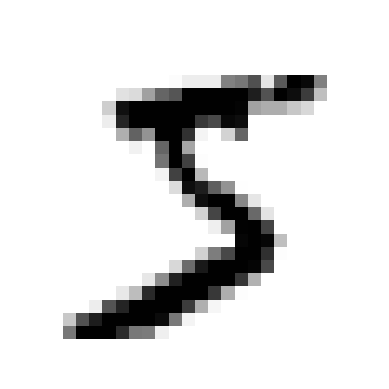

In [4]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are integers from 0 to 9:

In [5]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

Let's plot the first 40 elements of the dataset:

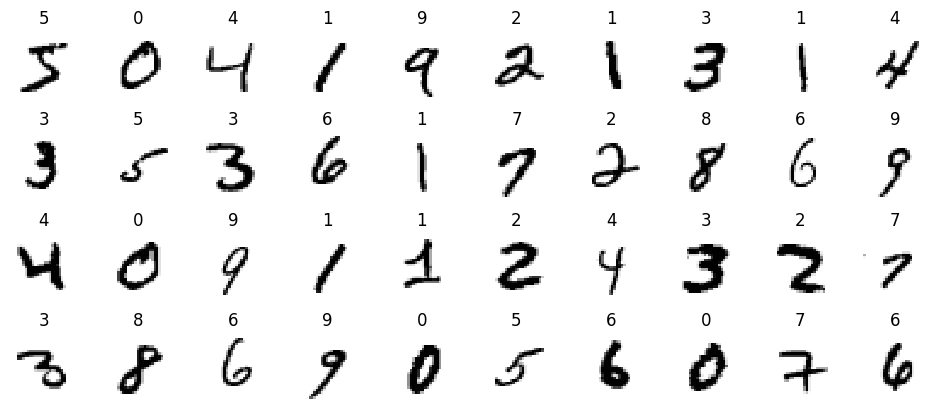

In [6]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index])
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

We will create a deep neural network with 8 layers adn with 128 neurons in each layer:

In [7]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.utils import to_categorical
from keras import optimizers

# Converts a class vector (integers) to binary class matrix.
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Define the neural network
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # Flattens the input turning  a 28x28 matrix into a 784 vector
#We use the sigmoidal activation function. It is particularly bad for the reasons explained in theory.
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(10, activation='softmax'))

#summary of the model
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,354 (849.04 KB)

 Trainable params: 217,354 (849.04 KB)

 Non-trainable params: 0 (0.00 B)

Now we will proceed to training. Before training, we have collected the average value of the weights of each layer in a list. These weights have been initialized randomly. After training, we will collect the weights again, and show in a bar chart the difference between the initial and final weights.

0.04059672
0.07635379
0.07636863
0.07645563
0.07627837
0.07652337
0.07688901
0.07825167
0.09756091
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 31s 16ms/step - accuracy: 0.1041 - loss: 2.3049 - val_accuracy: 0.1009 - val_loss: 2.3034


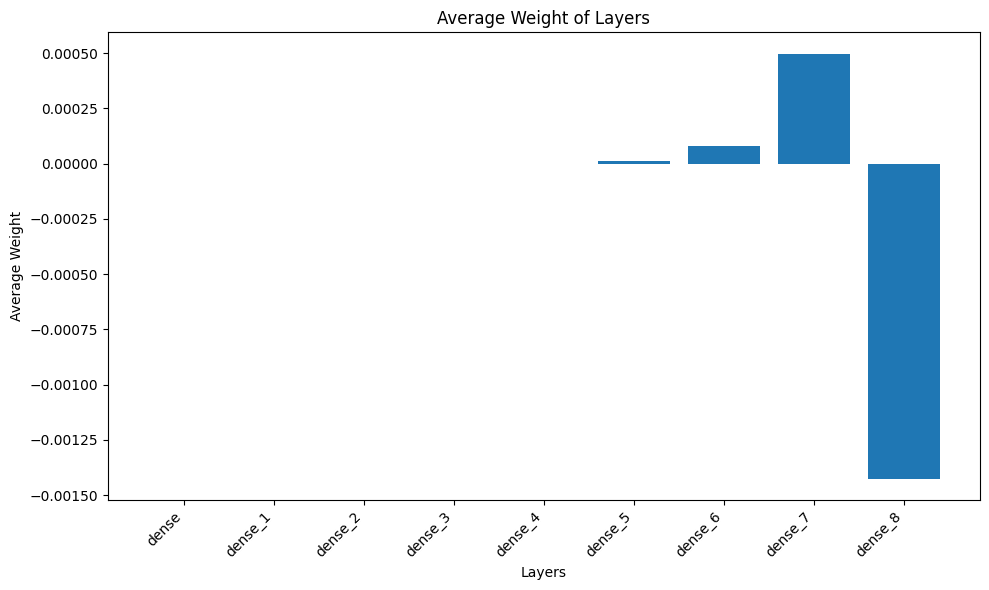

In [27]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=0.1)  # Use stochastic gradient descent
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# We collect the initial weights of each layer (randomly initialized) before optimization
average_weights_ini = []
layer_names = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    layer_names.append(layer.name)
    #ignore the biases
    weights = weights[0]
    average_weights_ini.append(np.mean(np.abs(weights)))

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# We collect the weights after training
average_weights = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    #ignore the biases
    weights = weights[0]
    average_weights.append(np.mean(np.abs(weights)))

# We plot the difference between the weights before and after training
diff_weights = [w1 - w2 for w1, w2 in zip(average_weights, average_weights_ini)]

plt.figure(figsize=(10, 6))
plt.bar(layer_names, diff_weights)
plt.xlabel("Layers")
plt.ylabel("Average Weight")
plt.title("Average Weight of Layers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

It can be observed that the gradient has been fading away; the last layer has seen its weights altered a little. The previous three layers have changed to a much lesser extent. But the first 5 layers have not changed at all. In this situation, it is obvious that the network has not learned. Let's see what the loss and the training and validation accuracy have been:

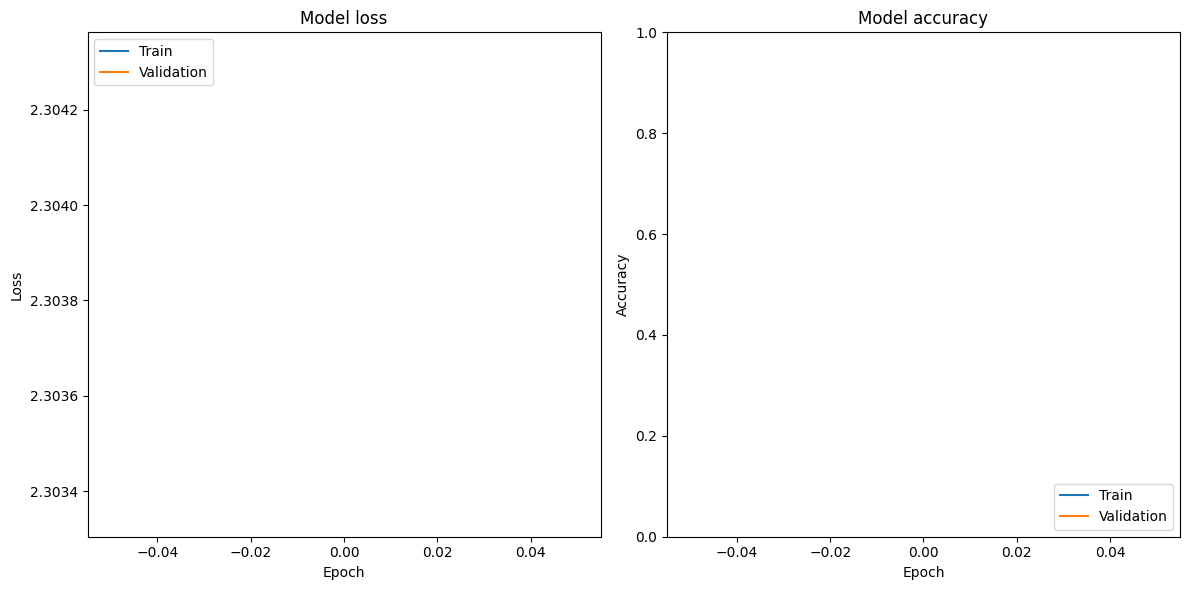

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

## Fixing the problem

Instead of using the sigmoidal function (which has a non-zero average value, in addition to being able to saturate the gradient for both small and high values) we use the relu function:


In [30]:

# Define the neural network
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))  # Flattens the input turning  a 28x28 matrix into a 784 vector
#We use the relual activation function. It is particularly bad for the reasons explained in theory.
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

#summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 217,354 (849.04 KB)

 Trainable params: 217,354 (849.04 KB)

 Non-trainable params: 0 (0.00 B)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.7244 - loss: 0.8357 - val_accuracy: 0.9534 - val_loss: 0.1642


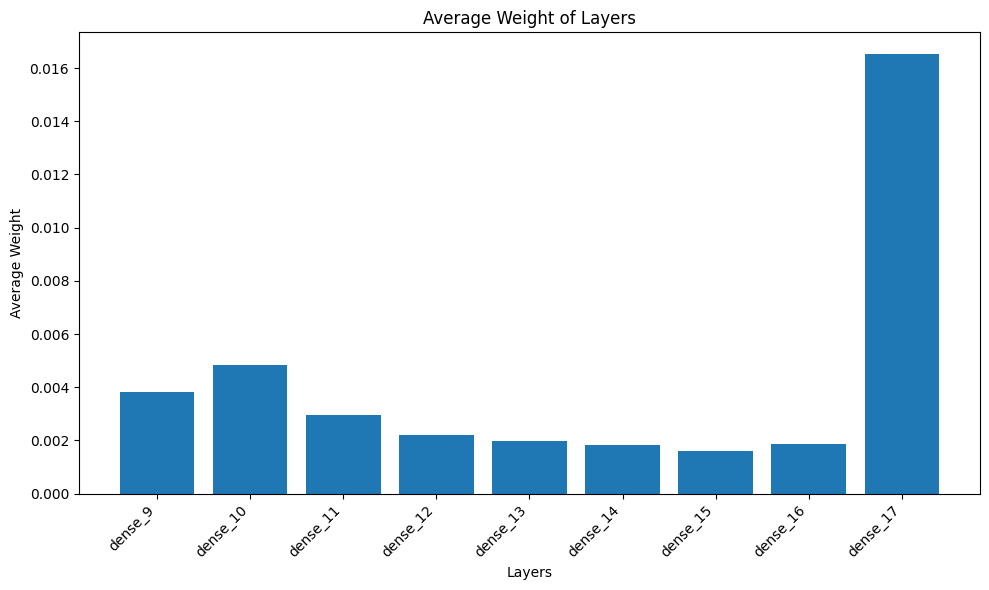

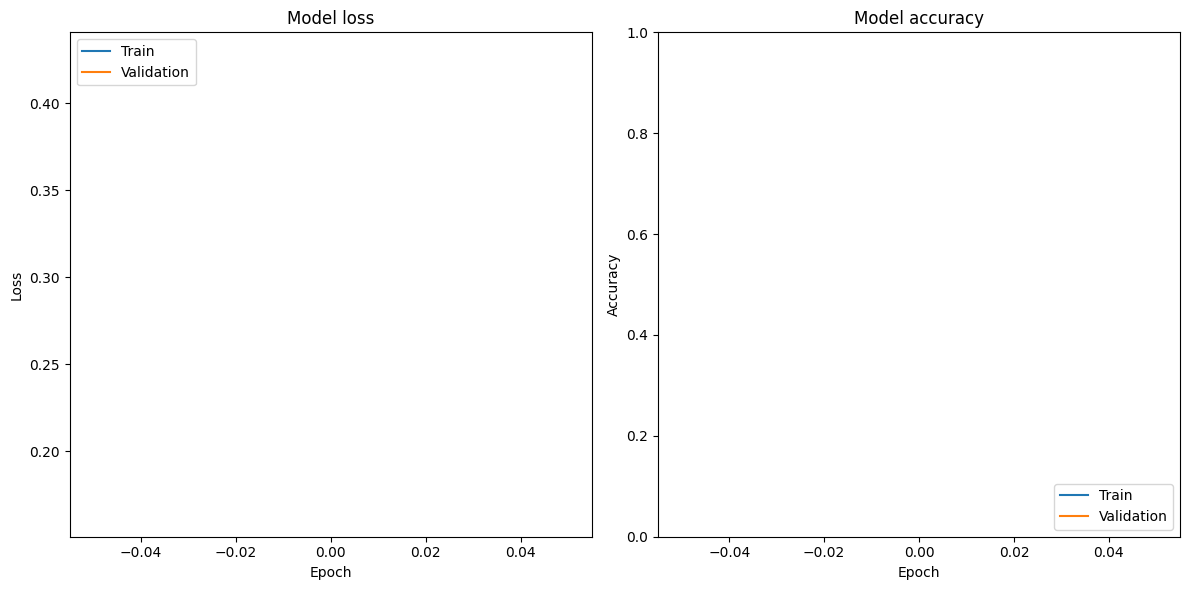

In [31]:
# Compile the model
optimizer = optimizers.SGD(learning_rate=0.1)  # Use stochastic gradient descent
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# We collect the initial weights of each layer (randomly initialized) before optimization
average_weights_ini = []
layer_names = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    layer_names.append(layer.name)
    #ignore the biases
    weights = weights[0]
    average_weights_ini.append(np.mean(np.abs(weights)))

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# We collect the weights after training
average_weights = []
for layer in model.layers:
  # We shall ignore the values of the biases
  weights = layer.get_weights()
  # If this is a trainable layer with weigths
  if weights:
    #ignore the biases
    weights = weights[0]
    average_weights.append(np.mean(np.abs(weights)))

# We plot the difference between the weights before and after training
diff_weights = [w1 - w2 for w1, w2 in zip(average_weights, average_weights_ini)]

plt.figure(figsize=(10, 6))
plt.bar(layer_names, diff_weights)
plt.xlabel("Layers")
plt.ylabel("Average Weight")
plt.title("Average Weight of Layers")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


# Exploding gradientes (probably)

Let's observe the same behavior on the iris dataset:

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


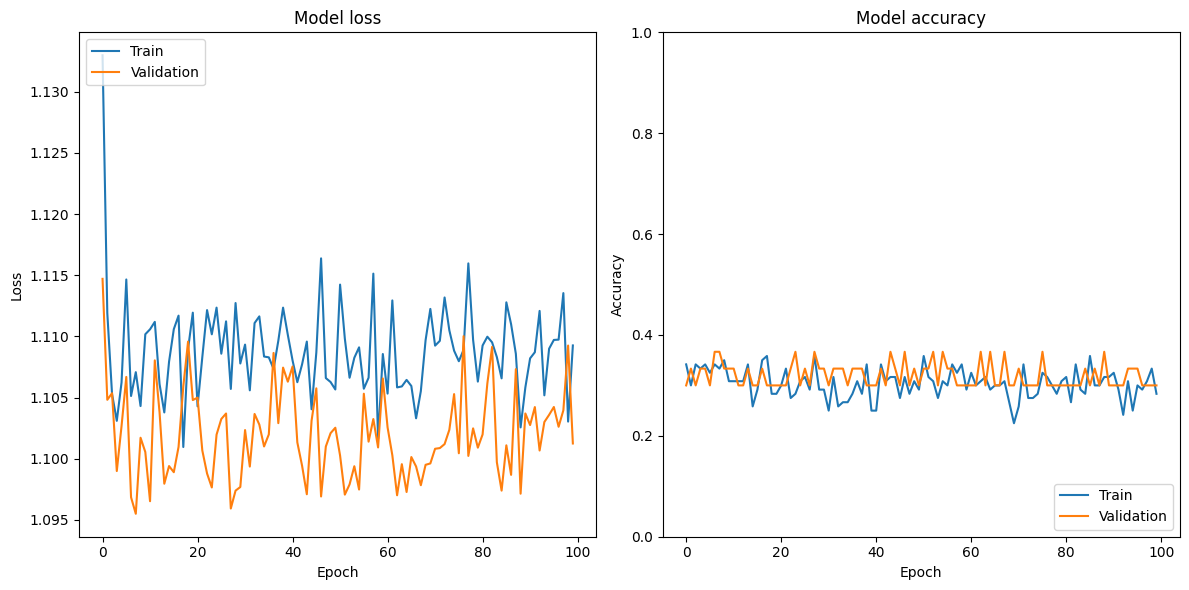

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

# Loading the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)

# Encode class labels in one-hot format
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Define the neural network (same architecture as before)
# It is excessively complex for a problem with 4 features and 150 data, but we do it for illustrative purposes.
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(4,)))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las 3 clases de Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


Note how if we had used a single layer, but with the same activation function size, we would have achieved a more or less reasonable training (and given the shape of the loss curves the training would probably benefit from continuing for more epochs):

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


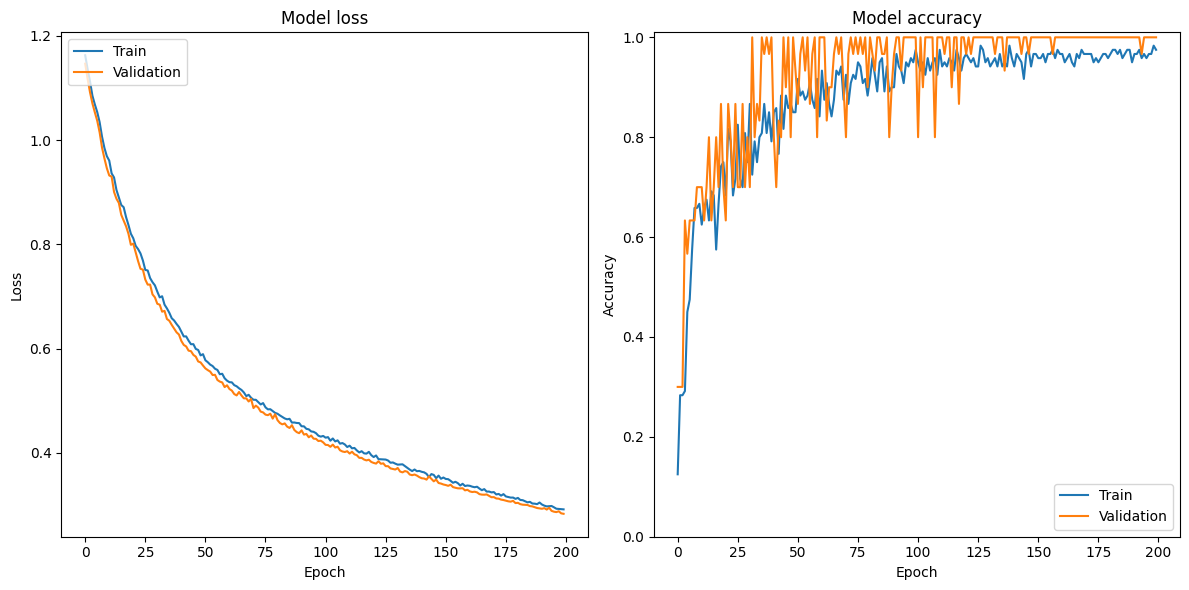

In [49]:
# Define the neural network (same architecture as befor
model = Sequential()
model.add(Dense(128, activation='sigmoid', input_shape=(4,)))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las 3 clases de Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

Note that if we use 8 capacitances and 128 neurons, as originally, but if we use a better activation function, the training is more reasonable.

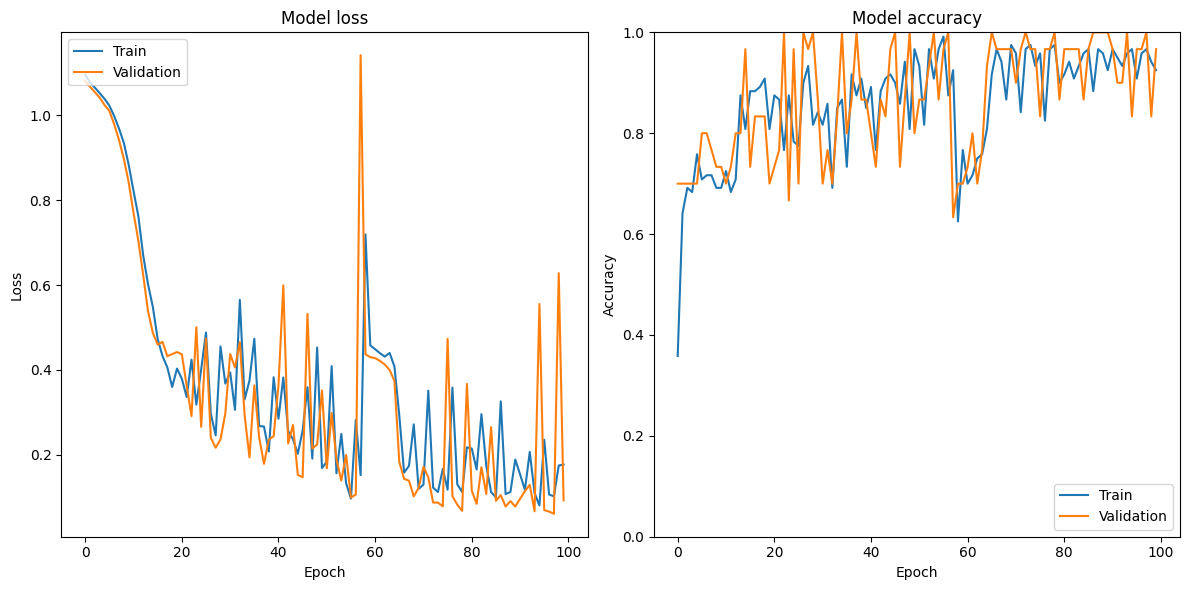

In [47]:
# Define the neural network (same architecture as befor
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(4,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las 3 clases de Iris

# Compile the model
optimizer = optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1.01])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()


And using a more modern optimizer (Adam) without having to change the learning rate (in the previous examples I had to use 0.01 to get more reasonable results; if you change it it will probably get worse) we get a much faster convergence (about 10 epochs)

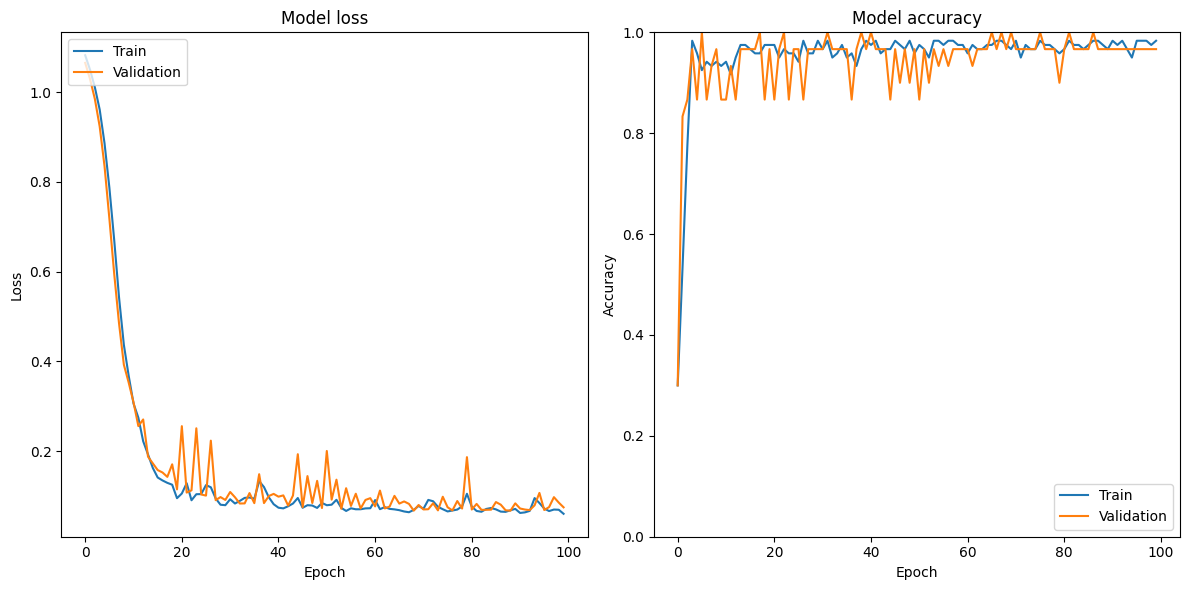

In [58]:
# Define the neural network (same architecture as befor
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(4,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 3 neuronas de salida para las 3 clases de Iris

# Compile the model
optimizer = optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=100, batch_size=10, validation_data=(X_test, y_test), verbose=0)

plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.ylim([0, 1])  # Set y-axis range for accuracy

plt.tight_layout()
plt.show()

If you set the learning rate to 0.0001 (Adam(learning_rate=0.0001)) in the above example, the training rate is quite reasonable. With good activation functions and optimizers, we have managed to train this ridiculously complex (for the problem at hand) neural network.
